# Initialization

In [1]:
# Enable interactive plot
%matplotlib widget

### Animation Functions

In [2]:
def init():
    recon_line.set_data([], [])
    sparsity_line.set_data([], [])
    return (
        recon_line,
        sparsity_line,
    )


def train_model(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    sparsity_line.set_data(data["batch_index"], data["sparsity"])
    recon_line.set_data(data["batch_index"], data["trace_recon_error"])
    return (
        recon_line,
        sparsity_line,
    )

In [3]:
def animation_monitor(i, batch_index=[], sparsity=[], recon_error=[]):
    print(i)
    plt.cla()
    data = pd.read_csv("results.csv")
    sparsity_line.set_data(data["batch_index"], data["sparsity"])
    recon_line.set_data(data["batch_index"], data["trace_recon_error"])
    plt.plot(data["batch_index"], data["sparsity"], c="r", label="Sparsity")
    plt.plot(data["batch_index"], data["trace_recon_error"], c="green", label="Recon Error")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()
    return (
        recon_line,
        sparsity_line,
    )

### Hyper-parameters (variables)

In [4]:
PRINT_FREQ = 1  # sparsity calculations' print frequency w/ modulus operandi.
KERNEL_SIZE = 9  # Kernel value of the dimensions for convolutional features.
WINDOW_SIZE = 7  # number of frames for each windowed video batch
batch_split = 35  # number of splits for each window video batch
LCA_ITERS = 1000  # number of LCA timesteps per forward pass
FEATURES = 50  # number of dictionary features to learn
LAMBDA = 2  # neuron activation threshold
STRIDE = 2  # LCA convolutional stride
EPOCHS = 1  # periods of training
TAU = 200  # LCA time constant

### Dependencies

In [2]:
# system modules
import csv
import glob
import itertools
import math
import os
import pickle
import time

import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# PyTorch module and methods
import torch
import torch.nn.functional as F
from jupyterplot import ProgressPlot

# numpy, scipy, pandas, matplotlib
from matplotlib.animation import FuncAnimation

# image processing modules
from PIL import Image
from scipy import stats
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid, save_image

# Progress bar module
from tqdm import tqdm

# local module for linked-dictionary LCA
from lcapt.analysis import make_feature_grid
from lcapt.lca import LCAConv1D, LCAConv2D, LCAConv3D
from lcapt.metric import compute_frac_active, compute_l1_sparsity, compute_l2_error
from lcapt.preproc import make_unit_var, make_zero_mean
from lcapt.pvutils import animate_energy

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        ...,

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
 

In [3]:
z = torch.zeros(140, 1000, 4)
z.shape

torch.Size([140, 140, 4])

# Datasets

### Video

In [6]:
%%time

i = 0
imgs = []

for img_path in sorted(glob.glob("../data/V1 Stimuli/natural_movie_three/*.png")):
    # print(img_path, imageio.imread(img_path).shape)
    imgs.append(imageio.imread(img_path))

torch_wf = torch.empty(
    size=(len(imgs) - WINDOW_SIZE + 1, WINDOW_SIZE, np.array(imgs).shape[-2], np.array(imgs).shape[-1])
)
imgs_arr = np.array(imgs)
print(imgs_arr.shape)

for ind, im in enumerate(imgs):
    if len(imgs_arr[i : i + WINDOW_SIZE]) == WINDOW_SIZE:
        torch_wf[ind] = torch.tensor(imgs_arr[i : i + WINDOW_SIZE])
        i += 1

print(torch_wf.size())

splitted10_wf = torch.split(torch_wf, 10, 0)
print("incomplete batch", splitted10_wf[-1].shape)
print("batches_amount(10r/b): ", len(splitted10_wf))

splitted6_wf = torch.split(torch_wf, batch_split, 0)
print("num of batches (splitted6_wf): ", len(splitted6_wf))

<timed exec>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


(3600, 160, 256)
torch.Size([3594, 7, 160, 256])
incomplete batch torch.Size([4, 7, 160, 256])
batches_amount(10r/b):  360
num of batches (splitted6_wf):  103
CPU times: user 11.8 s, sys: 2.91 s, total: 14.7 s
Wall time: 4.26 s


### Traces

##### Read dff dataset (4GB)

In [7]:
%%time
pickle.HIGHEST_PROTOCOL = 4

# IMPORTANT TO NOT UPLOAD dff.h5 IF REPO DEV
dff_df = pd.read_hdf("../data/V1 Responses/dff.h5")

CPU times: user 8.93 s, sys: 3.58 s, total: 12.5 s
Wall time: 12.5 s


##### simple split (fast)

In [8]:
%%time
counter = 0
exps_cells = []
column_exp = []
column_cell = []
complete_column_cell_exp_list = []

for column in dff_df.columns[7:]:
    complete_column_cell_exp_list.append(column)
    column_cell.append(column.split("_")[0])
    column_exp.append(column.split("_")[1])

new_column_exp = np.unique(column_exp)

print("Average cell count per experiment:")
print(
    len(np.unique(column_cell)) // len(np.unique(column_exp)),
    "=",
    len(np.unique(column_cell)),
    "//",
    len(np.unique(column_exp)),
)

for exp_index in range(15, 22):
    for cell_exp in complete_column_cell_exp_list:
        if str(cell_exp).endswith(new_column_exp[exp_index]):
            # print(f'Cell {cell_exp} has been traced with experiment {new_column_exp[0]}')
            exps_cells.append(cell_exp)
            counter += 1

print("cells:", counter)

Average cell count per experiment:
247 = 12380 // 50
cells: 1220
CPU times: user 89.4 ms, sys: 0 ns, total: 89.4 ms
Wall time: 87.5 ms


##### dataframe (using all repetitions or first repetition only of each cel)

In [9]:
%%time
# time consuming (2-3 min)
dff_exps = dff_df[["frame", "repeat", "stimulus", "session_type", *exps_cells]]
dff_exps_movie3_list = []

for exp_cell in exps_cells:
    if dff_exps[dff_exps["stimulus"] == "natural_movie_three"][exp_cell].values.all() == False:
        dff_exp_cell = dff_exps[["stimulus", exp_cell]].where(dff_exps["stimulus"] == "natural_movie_three").dropna()
        dff_exp_rep = torch.tensor(dff_exp_cell[exp_cell].values)
        dff_exp_movie_tensors = torch.split(dff_exp_rep, 3600, 0)
        for ind, dff_exp_sample in enumerate(dff_exp_movie_tensors):
            # ind == 0 is only using the first repetition per cell
            if ind == 0:
                dff_exps_movie3_list.append(dff_exp_sample)
            # dff_exps_movie3_list.append(dff_exp_sample)
dff_exps_movie3 = torch.stack(dff_exps_movie3_list)
print(dff_exps_movie3.shape, len(dff_exps_movie3))

torch.Size([511, 3600]) 511
CPU times: user 28min 23s, sys: 2min 4s, total: 30min 27s
Wall time: 2min 42s


##### tensor split (fast)

In [10]:
torch_wt = torch.empty(
    size=(len(dff_exps_movie3_list), dff_exps_movie3.shape[1] - WINDOW_SIZE + 1, WINDOW_SIZE)
).cuda()

for trace_ind, trace in enumerate(dff_exps_movie3):
    torch_wt[trace_ind] = torch.from_numpy(
        np.lib.stride_tricks.sliding_window_view(dff_exps_movie3[trace_ind].cpu().numpy(), window_shape=WINDOW_SIZE)
    )

splitted10_wt = torch.split(torch.moveaxis(torch_wt, 1, 0), 10, 0)
print(torch_wt.shape, torch_wt[trace_ind].shape, splitted10_wt[-1].shape, len(splitted10_wt))

torch.Size([511, 3594, 7]) torch.Size([3594, 7]) torch.Size([4, 511, 7]) 360


/tmp/ipykernel_3437148/587190963.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  torch_wt[trace_ind] = torch.from_numpy(np.lib.stride_tricks.sliding_window_view(


##### dffMedianMinMax process (not needed)

In [11]:
%%time
# not needed
dff_movie3_lists = []
dff_cells_movie3_list = []

for exps_cell in splitted10_wt:
    dff_cells_movie3_list.append(exps_cell)
    if len(dff_cells_movie3_list) == 100:
        dff_batch = list(map(torch.stack, zip(*dff_cells_movie3_list)))
        # print(len(dff_cells_movie3_list), len(dff_batch))
        dff_movie3_lists.append(dff_batch)
        dff_cells_movie3_list.clear()

print(len(dff_movie3_lists), len(dff_movie3_lists[0]), len(dff_movie3_lists[0][0]))

dff_tuple = tuple(map(torch.stack, zip(*dff_movie3_lists)))

print(dff_exps_movie3.shape, len(dff_exps_movie3))
print(splitted10_wt[0].shape, len(splitted10_wt))

print("number of dff_tuple:", len(dff_tuple))
print(dff_tuple[0].shape)

dff_movie3_tuples_list = []
df = pd.DataFrame({"min": [], "med": [], "max": []})

for ind, dff_exp_movie3_rep in enumerate(dff_exps_movie3):
    # print('index:', ind, 'median:', torch.median(dff_sample0movie3_rep.cuda()))
    # print('max:', torch.max(dff_sample0movie3_rep), 'min:', torch.min(dff_sample0movie3_rep))
    dff_movie3_tuples_list.append((dff_exp_movie3_rep.unsqueeze(0), len(dff_exp_movie3_rep), 3))
    df.loc[len(df.index)] = [
        torch.min(dff_exp_movie3_rep).cpu().numpy(),
        torch.median(dff_exp_movie3_rep.cuda()).cpu().numpy(),
        torch.max(dff_exp_movie3_rep).cpu().numpy(),
    ]

df.to_csv("../tables/MedianMinMaxMovie3Exps15to21.csv")

3 10 100
torch.Size([511, 3600]) 511
torch.Size([10, 511, 7]) 360
number of dff_tuple: 10
torch.Size([3, 100, 511, 7])
CPU times: user 1.04 s, sys: 7.97 ms, total: 1.04 s
Wall time: 1.04 s


# LCA Training 

### Model Initialization

In [12]:
lca = LCAConv3D(
    140,
    1,
    "NEWfixedVid_linked_testing",
    9,
    9,
    7,
    2,
    2,
    1,
    2,  # lca_thresh = lambda
    no_time_pad=True,
    lca_iters=1000,
)


with torch.no_grad():
    ckpt = torch.load("../models/lca_imagenet_vid_dict.pth")
    # torch.set_default_tensor_type(torch.cuda.FloatTensor)
    lca.assign_weight_values(ckpt.module.weights)
    # print('starting...')

    # windowed_frames_batch = splitted10_wf[0]
    # windowed_traces_batch = splitted10_wt[0]
    # windowed_frames_batch = torch.unsqueeze(windowed_frames_batch.cuda(), 1)
    # windowed_frames_batch = make_unit_var(make_zero_mean(windowed_frames_batch))
    # windowed_traces_batch = make_unit_var(make_zero_mean(windowed_traces_batch[:, :100]))

    # print('booting...')
    # code = lca((windowed_frames_batch.cuda(), windowed_traces_batch.cuda()))

    # print('finished...')
    # recon, trace_recon = lca.compute_recon(code, lca.weights, True)
    # print(trace_recon.shape)


lca = torch.nn.DataParallel(lca).cuda()
lca.n_cells = 100  # change to how many cells used
pp = ProgressPlot(
    plot_names=["l1_sparsity", "l2_trace_recon_error"], x_lim=[0, len(splitted10_wt)], y_lim=[[0, 1000000], [0, 1000]]
)

<IPython.core.display.Javascript object>

### Input Feed and Saving

0 2
1 2
plotting...


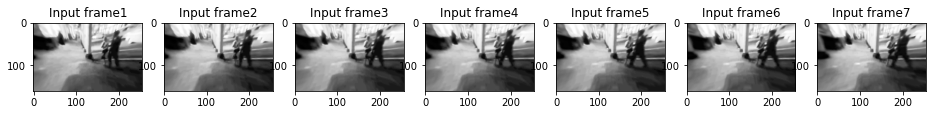

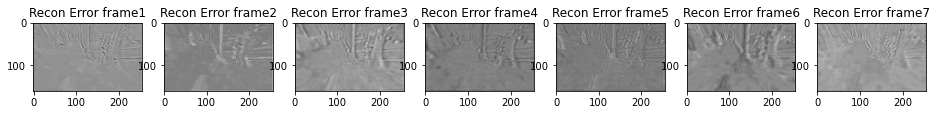

2 2
plotting...


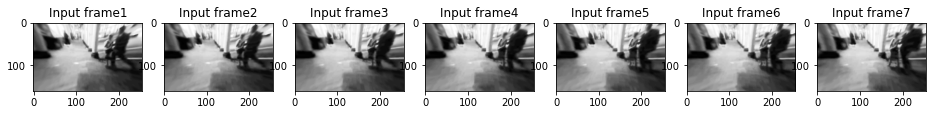

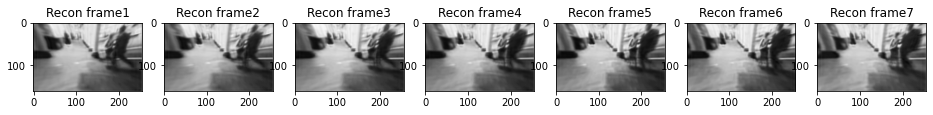

3 2
plotting...


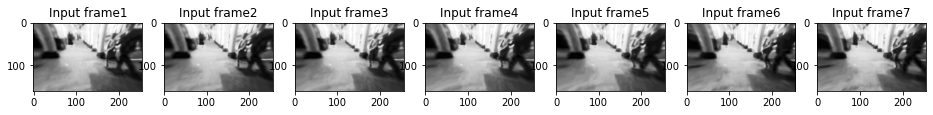

4 2
plotting...


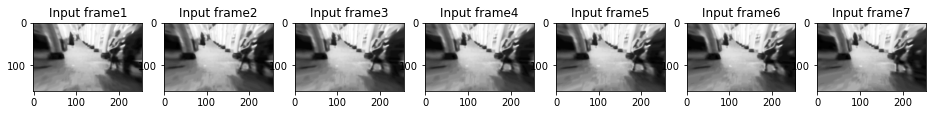

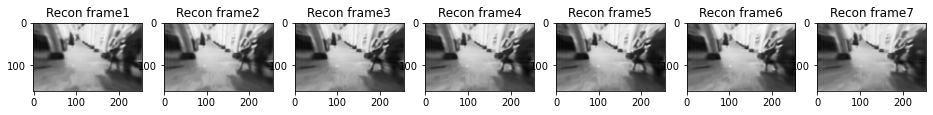

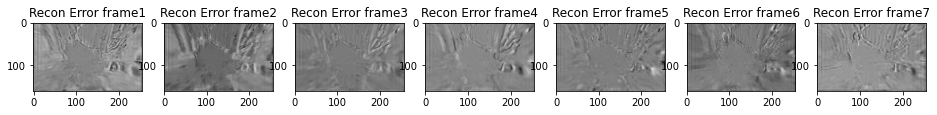

5 2
6 2
7 2
8 2
9 2
10 2
11 2
12 2
13 2
14 2
15 2
16 2
17 2
18 2
19 2
20 2
21 2
22 2
23 2
24 2
25 2
26 2
27 2
28 2
29 2
30 2
31 2
32 2
33 2
34 2
35 2
36 2
37 2
38 2
39 2
40 2
41 2
42 2
43 2
44 2
45 2
46 2
47 2
48 2
49 2
50 2
51 2
52 2
53 2
54 2
55 2
56 2
57 2
58 2
59 2
60 2
61 2
62 2
63 2
64 2
65 2
66 2
67 2
68 2
69 2
70 2
71 2
72 2
73 2
74 2
75 2
76 2
77 2
78 2
79 2
80 2
81 2
82 2
plotting...


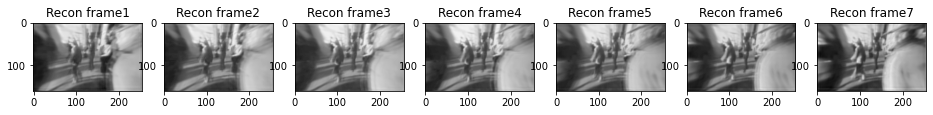

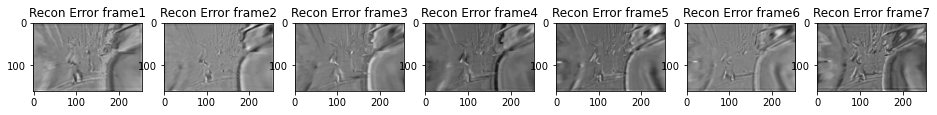

83 2
plotting...


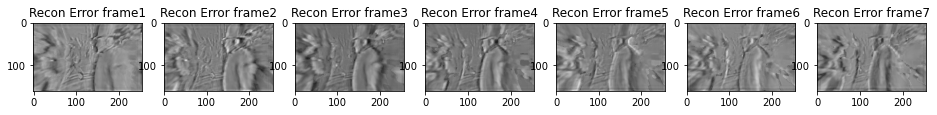

84 2
plotting...


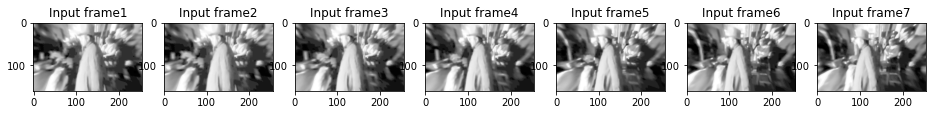

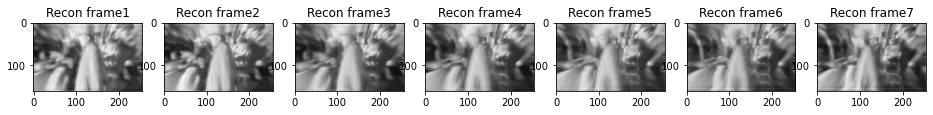

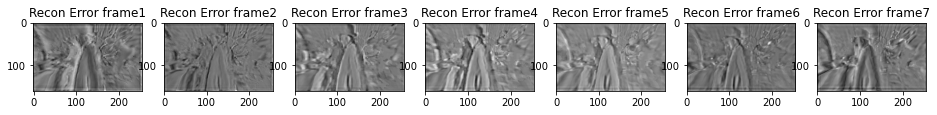

85 2
plotting...


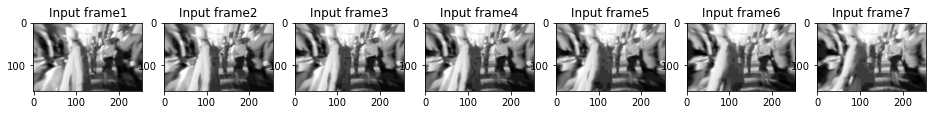

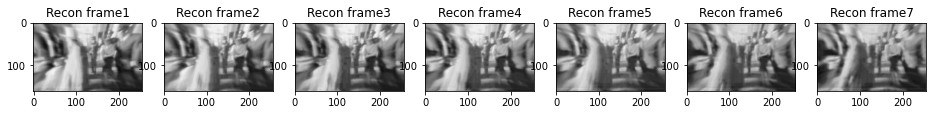

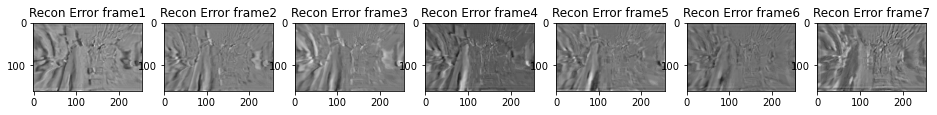

86 2
plotting...


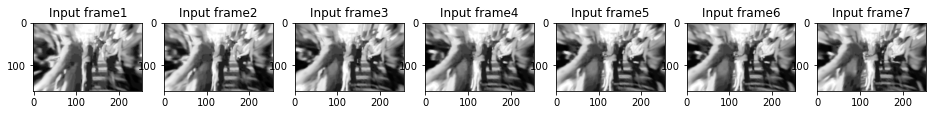

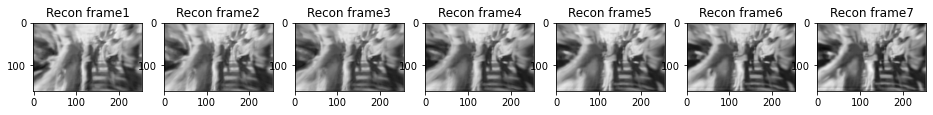

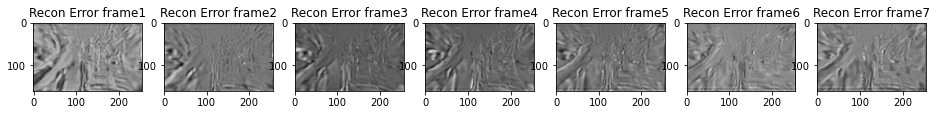

87 2
plotting...


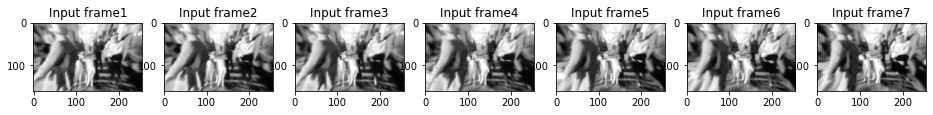

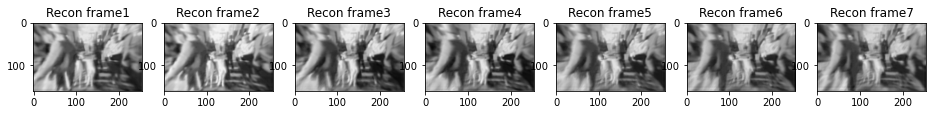

88 2
plotting...


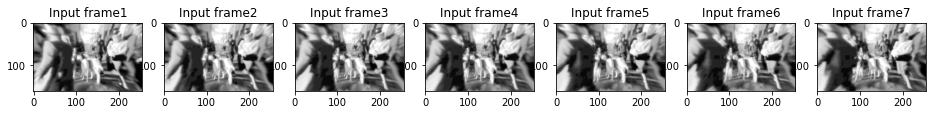

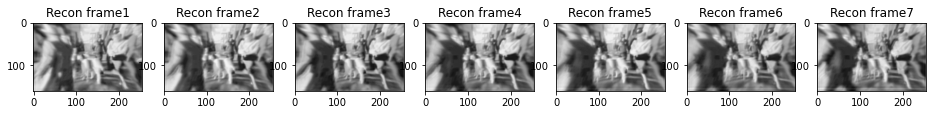

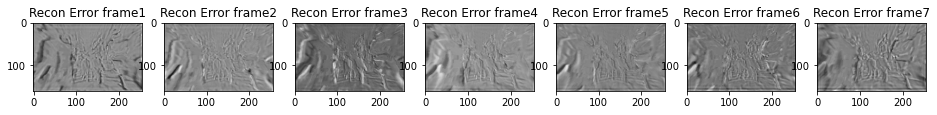

89 2
90 2
91 2
92 2
93 2
94 2
95 2
96 2
97 2
98 2
99 2
100 2
101 2
102 2
103 2
104 2
105 2
106 2
107 2
108 2
109 2
110 2
111 2
112 2
113 2
114 2
115 2
116 2
117 2
118 2
119 2
120 2
121 2
122 2
123 2
124 2
125 2
126 2
127 2
128 2
129 2
130 2
131 2
132 2
133 2
134 2
135 2
136 2
137 2
138 2
139 2
140 2
141 2
142 2
143 2
144 2
145 2
146 2
147 2
148 2
149 2
150 2
151 2
152 2
153 2
154 2
155 2
156 2
157 2
158 2
159 2
160 2
161 2
162 2
163 2
164 2
165 2
166 2
167 2
168 2
169 2
170 2
171 2
172 2
173 2
174 2
175 2
176 2
177 2
178 2
179 2


In [13]:
%matplotlib inline
# plot feature responses over time (max pool or ave. pool)
# plot mice neuron responses (per neuron) for the same stimuli
# trying to match the feature over time with the neuron responses
# average out the repetitions of each cells' responses to compare with feature responses over time
# average
acts_list = []
recon_list = []
recon_error_list = []
trace_recon_list = []
trace_recon_error_list = []
pp = ProgressPlot(
    plot_names=["l1_sparsity", "l2_trace_recon_error"],
    x_lim=[0, len(splitted10_wt) // 2],
    y_lim=[[0, 1000000], [0, 1000]],
)
for ind, (windowed_frames_batch, windowed_traces_batch) in enumerate(
    zip(splitted10_wf[: len(splitted10_wf) // 2], splitted10_wt[: len(splitted10_wt) // 2])
):
    print(ind, lca.module.lambda_)

    windowed_frames_batch = windowed_frames_batch.cuda()
    windowed_frames_batch = torch.unsqueeze(windowed_frames_batch, 1)
    windowed_frames_batch = make_unit_var(make_zero_mean(windowed_frames_batch))

    windowed_traces_batch = make_unit_var(make_zero_mean(windowed_traces_batch[:, :100].cuda()))

    code = lca((windowed_frames_batch, windowed_traces_batch))

    recon, trace_recon = lca.module.compute_recon(code, lca.module.weights, True)

    recon_error = windowed_frames_batch - recon
    trace_recon_error = windowed_traces_batch - trace_recon

    lca.module.update_weights(code, windowed_frames_batch - recon, windowed_traces_batch - trace_recon, ind)

    # mse = 0.5 * (recon_error.norm(p=2, dim=tuple(range(1, len(recon_error.shape)))) ** 2).mean()

    # if ind % PRINT_FREQ == 0:
    l1_sparsity = compute_l1_sparsity(code, lca.module.lambda_).item()
    l2_recon_error = compute_l2_error(windowed_frames_batch, recon).item()
    l2_trace_recon_error = compute_l2_error(windowed_traces_batch, trace_recon).item()
    total_energy = l2_recon_error + l1_sparsity + l2_trace_recon_error
    pp.update([[l1_sparsity], [l2_trace_recon_error]])

    # print(f'L2 Trace Recon Error: {round(l2_trace_recon_error, 2)}; ',
    #         f'L2 Recon Error: {round(l2_recon_error, 2)}; ',
    #         f'L1 Sparsity: {round(l1_sparsity, 2)};  ',
    #         f'Total Energy: {round(total_energy, 2)};')
    # print(f'acts_all: {code.shape}, nonzero_counter on activity: {torch.count_nonzero(code)} out of {torch.numel(code)}')
    # group the neurons by feature (looking at video)
    acts_list.append(code)
    recon_list.append(recon)
    recon_error_list.append(recon_error)
    trace_recon_list.append(trace_recon)
    trace_recon_error_list.append(trace_recon_error)

    if ind > 0 and ind < 5:
        print("plotting...")
        fig1, axs1 = plt.subplots(1, 7, figsize=(16, 9))
        fig2, axs2 = plt.subplots(1, 7, figsize=(16, 9))
        fig3, axs3 = plt.subplots(1, 7, figsize=(16, 9))
        for a_ind, (a1, a2, a3) in enumerate(zip(axs1, axs2, axs3)):
            trace_recon_error = windowed_traces_batch - trace_recon
            trace_recon_samples = trace_recon[0].squeeze().squeeze().cpu().numpy()

            recon_error = windowed_frames_batch - recon
            recon_samples = recon[0].squeeze().squeeze().cpu().numpy()
            recon_error_samples = recon_error[0].squeeze().squeeze().cpu().numpy()

            recon_sample = recon_samples[a_ind]
            recon_error_sample = recon_error_samples[a_ind]
            inputs_sample = recon_error_sample + recon_sample

            recon_sample = (recon_sample - recon_sample.min()) / (recon_sample.max() - recon_sample.min())
            inputs_sample = (inputs_sample - inputs_sample.min()) / (inputs_sample.max() - inputs_sample.min())

            img1 = a1.imshow(inputs_sample, cmap="gray")
            img2 = a2.imshow(recon_sample, cmap="gray")
            img3 = a3.imshow(recon_error_sample, cmap="gray")

            a1.set_title(f"Input frame{a_ind+1}")
            a2.set_title(f"Recon frame{a_ind+1}")
            a3.set_title(f"Recon Error frame{a_ind+1}")
        plt.show()
        plt.close()

    if ind > 81 and ind < 89:
        print("plotting...")
        fig1, axs1 = plt.subplots(1, 7, figsize=(16, 9))
        fig2, axs2 = plt.subplots(1, 7, figsize=(16, 9))
        fig3, axs3 = plt.subplots(1, 7, figsize=(16, 9))
        for a_ind, (a1, a2, a3) in enumerate(zip(axs1, axs2, axs3)):
            trace_recon_error = windowed_traces_batch - trace_recon
            trace_recon_samples = trace_recon[0].squeeze().squeeze().cpu().numpy()

            recon_error = windowed_frames_batch - recon
            recon_samples = recon[0].squeeze().squeeze().cpu().numpy()
            recon_error_samples = recon_error[0].squeeze().squeeze().cpu().numpy()

            recon_sample = recon_samples[a_ind]
            recon_error_sample = recon_error_samples[a_ind]
            inputs_sample = recon_error_sample + recon_sample

            recon_sample = (recon_sample - recon_sample.min()) / (recon_sample.max() - recon_sample.min())
            inputs_sample = (inputs_sample - inputs_sample.min()) / (inputs_sample.max() - inputs_sample.min())

            img1 = a1.imshow(inputs_sample, cmap="gray")
            img2 = a2.imshow(recon_sample, cmap="gray")
            img3 = a3.imshow(recon_error_sample, cmap="gray")

            a1.set_title(f"Input frame{a_ind+1}")
            a2.set_title(f"Recon frame{a_ind+1}")
            a3.set_title(f"Recon Error frame{a_ind+1}")
        plt.show()
        plt.close()

pp.finalize()
torch.save(lca, f"../models/plotVidFixLinkDict.pth")

torch.Size([1800, 100, 7])


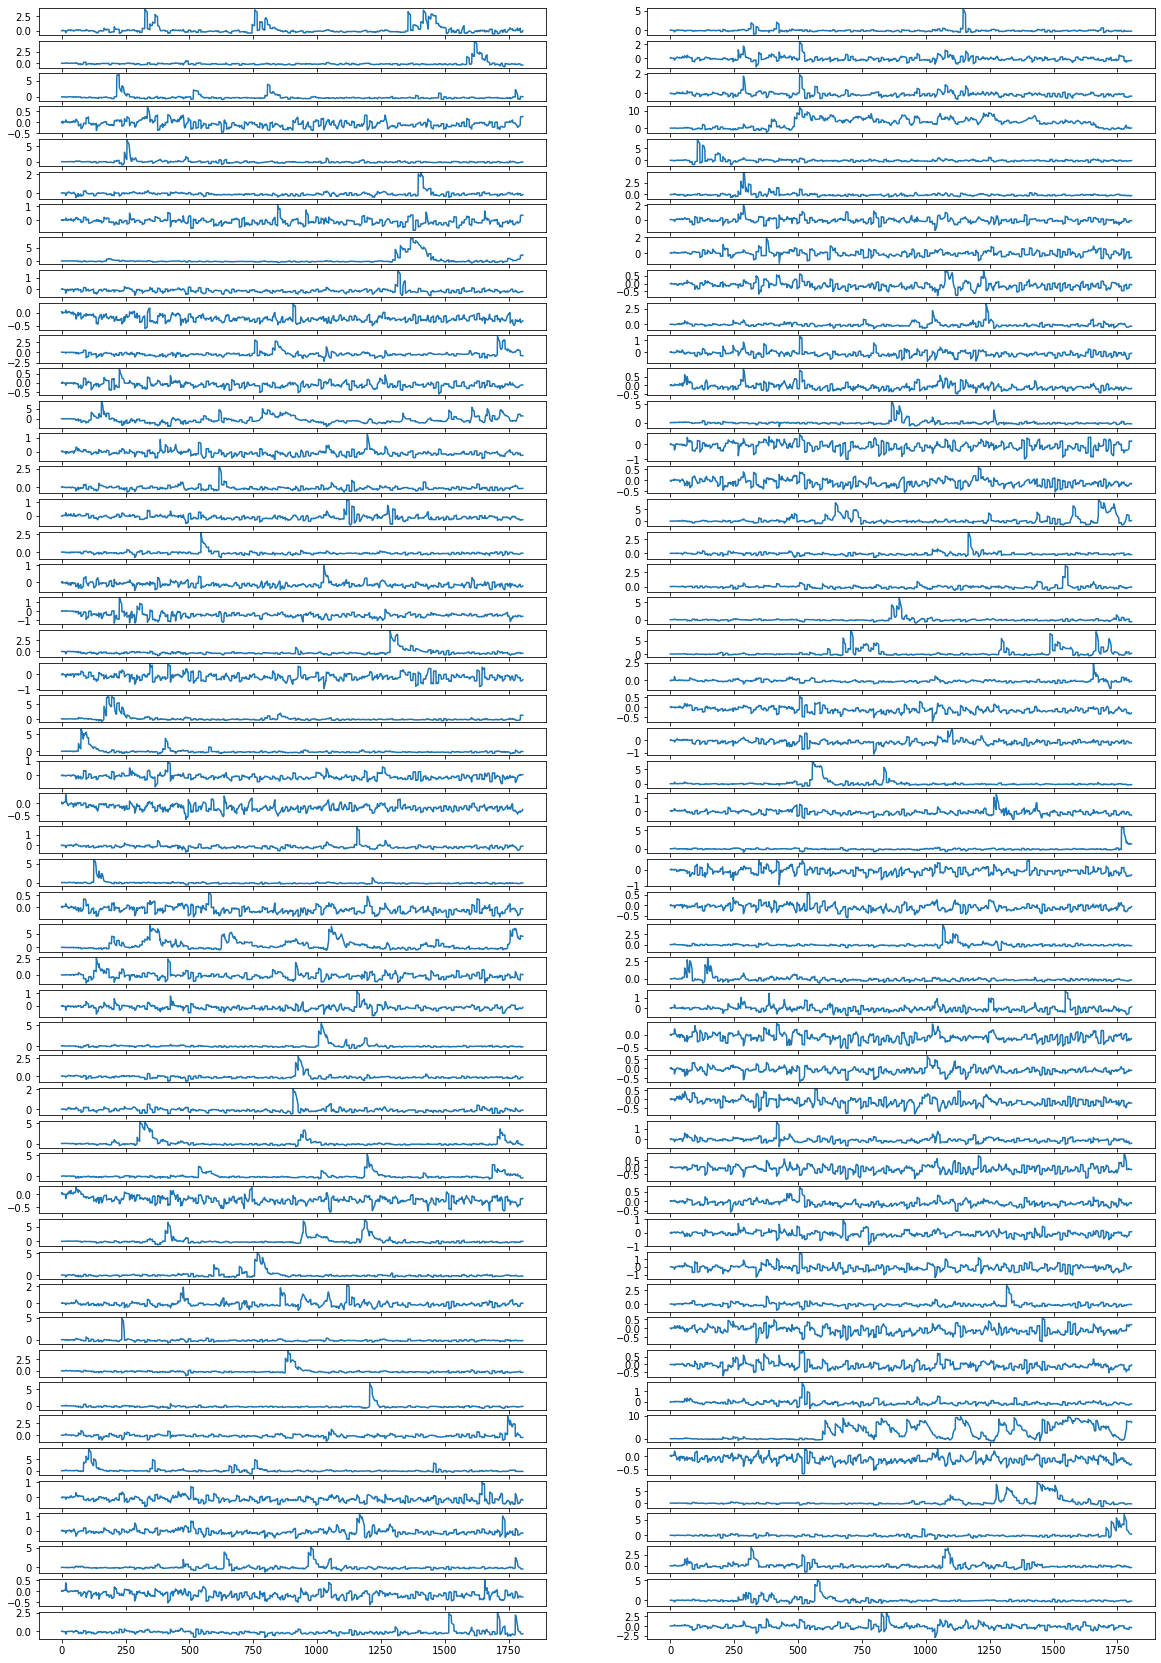

In [42]:
%matplotlib inline

new_trace_recon_list = []
for trace_recon_sample in trace_recon_list:
    new_trace_recon_list.append(trace_recon_sample.detach())

t_trace_recons = torch.stack(new_trace_recon_list)
t_trace_recons = torch.reshape(
    t_trace_recons,
    (t_trace_recons.shape[0] * t_trace_recons.shape[1], t_trace_recons.shape[-2], t_trace_recons.shape[-1]),
)
print(t_trace_recons.shape)

fig, axs = plt.subplots(50, 2, figsize=(20, 30))
for i in range(t_trace_recons.shape[-2]):
    plot_trace_recon_list = []
    for j in range(t_trace_recons.shape[0]):
        if j == 0:
            for k in range(t_trace_recons.shape[-1]):
                plot_trace_recon_list.append(t_trace_recons[j, i, k].cpu().numpy())
        else:
            plot_trace_recon_list.append(t_trace_recons[j, i, -1].cpu().numpy())
    t_plot_trace_recons = np.array(plot_trace_recon_list)
    if i < t_trace_recons.shape[-2] // 2:
        axs[i, 0].plot(t_plot_trace_recons)
    else:
        axs[i - (t_trace_recons.shape[-2] // 2), 1].plot(t_plot_trace_recons)
plt.show()

In [45]:
%matplotlib inline

# print(len(acts_list))
# for act_ind, act_sample in enumerate (acts_list):
# 	if act_ind == 0: print(act_sample.shape, act_sample)

new_acts_list = []
for acts_sample in acts_list:
    acts_sample = acts_sample.cpu()
    new_acts_list.append(acts_sample.cpu())

t_acts = torch.stack(new_acts_list).to("cpu")
t_acts = torch.reshape(
    t_acts.squeeze(), (t_acts.shape[0] * t_acts.shape[1], t_acts.shape[2], t_acts.shape[-2], t_acts.shape[-1])
)
print(t_acts.shape)
for i in range(t_acts.shape[1]):
    if not os.path.exists(f"../reports/images_acts/cell{i+1}lca/"):
        os.makedirs(f"../reports/images_acts/cell{i+1}lca/")
    act_imgs = []

    for j in range(t_acts.shape[0]):
        save_image(t_acts[j, i, :, :], f"../reports/images_acts/cell{i+1}lca/img{j}.png")

    for act_path in sorted(glob.glob(f"../reports/images_acts/cell{i+1}lca/*.png")):
        # print(img_path, imageio.imread(img_path).shape)
        act_imgs.append(imageio.imread(act_path))

    imageio.mimsave(f"../reports/movies_acts/movie_lca_cell_{i+1}.gif", act_imgs)
plt.show()

torch.Size([1800, 140, 80, 128])


/tmp/ipykernel_3437148/2428637601.py:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  act_imgs.append(imageio.imread(act_path))


# Visualizations

### Pre-trained LCA Vis

In [16]:
# %matplotlib inline
# # ONLY if loading from pre-trained model
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# pretrain_lca = torch.load('../models/plotVidFixLinkDict.pth', map_location=device)

# windowed_frames_batch = torch.unsqueeze(splitted10_wf[100], 1).to(device)
# windowed_traces_batch = splitted10_wt[100][:, :100].to(device)

# code = pretrain_lca((windowed_frames_batch, windowed_traces_batch))
# recon, trace_recon = pretrain_lca.module.compute_recon(code, pretrain_lca.module.weights, True)

# pretrain_lca.module.update_weights(code, windowed_frames_batch - recon, windowed_traces_batch - trace_recon, len(splitted10_wt))
# fig1, axs1 = plt.subplots(1,7, figsize=(16,9))
# fig2, axs2 = plt.subplots(1,7, figsize=(16,9))
# fig3, axs3 = plt.subplots(1,7, figsize=(16,9))
# for a_ind, (a1, a2, a3) in enumerate(zip(axs1, axs2, axs3)):
#     trace_recon_error = windowed_traces_batch - trace_recon
#     trace_recon_samples = trace_recon[0].squeeze().squeeze().cpu().numpy()

#     recon_error = windowed_frames_batch - recon
#     recon_samples = recon[0].squeeze().squeeze().cpu().numpy()
#     recon_error_samples = recon_error[0].squeeze().squeeze().cpu().numpy()


#     recon_sample = recon_samples[a_ind]
#     recon_error_sample = recon_error_samples[a_ind]
#     inputs_sample = (recon_error_sample + recon_sample)

#     recon_sample = (recon_sample - recon_sample.min()) / (recon_sample.max() - recon_sample.min())
#     inputs_sample = (inputs_sample - inputs_sample.min()) / (inputs_sample.max() - inputs_sample.min())

#     img1 = a1.imshow(inputs_sample, cmap='gray')
#     img2 = a2.imshow(recon_sample, cmap='gray')
#     img3 = a3.imshow(recon_error_sample, cmap='gray')

#     a1.set_title(f'Input frame{a_ind+1}')
#     a2.set_title(f'Recon frame{a_ind+1}')
#     a3.set_title(f'Recon Error frame{a_ind+1}')
# plt.show()
# plt.close()

In [17]:
# T = pretrain_lca.module.weights.shape[2]
# grids = []
# for t in range(T):
#     grids.append(make_grid(pretrain_lca.module.weights[:, :, t],
#                            int(math.sqrt(pretrain_lca.module.weights.shape[0])),
#                            normalize=False, scale_each=False, pad_value=0.5).cpu())
# final_grids = torch.stack(grids).permute(0, 2, 3, 1)
# imageio.mimwrite(f"../reports/plotVidFixLinkDict.gif", final_grids.cpu().numpy(), "gif")
# exp_weight_grid = make_feature_grid(pretrain_lca.module.trace_weights[:, 0].squeeze(-1).moveaxis(1, -1))
# weight_grid = make_feature_grid(pretrain_lca.module.trace_weights.squeeze(-1).squeeze(-1))
# # arrange by neuron activation frequency (maximum to minimum)
# for i in range(exp_weight_grid.shape[0] % PRINT_FREQ + 10):
#     plt.plot(exp_weight_grid[i].cpu().numpy())
#     # plt.plot(weight_grid[i].cpu().numpy())
#     plt.grid()
#     plt.show()
#     plt.close()

In [18]:
# for i in range(len(trace_recon_error)):

#     plt.close()
#     fig, axs = plt.subplots(1, 2, figsize=(30, 20))

#     axs[0].plot((trace_recon_error[i, 0] + trace_recon[i, 0]).cpu().numpy(), linewidth=2, label = 'input')
#     axs[0].plot(trace_recon.cpu().numpy()[i, 0], c='r', linewidth=2, label = 'reconstruction')

#     axs[1].plot(trace_recon_error[i, 0].cpu().numpy(), c='g')

#     axs[0].set_title('Trace Input and Reconstruction')
#     axs[1].set_title('Trace Reconstruction Error')
#     axs[0].legend(loc='upper right')
#     plt.axis('tight')
#     axs[1].grid()
#     axs[0].grid()
#     plt.show()

### Video Reconstruction

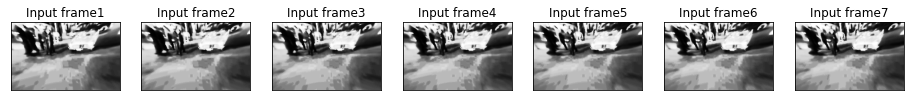

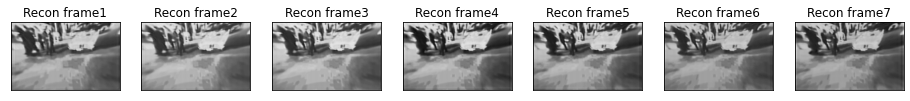

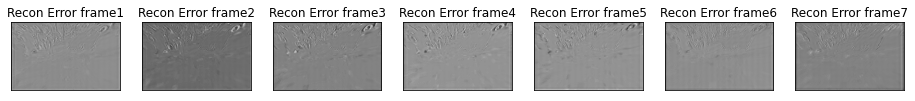

In [19]:
fig1, axs1 = plt.subplots(1, 7, figsize=(16, 9))
fig2, axs2 = plt.subplots(1, 7, figsize=(16, 9))
fig3, axs3 = plt.subplots(1, 7, figsize=(16, 9))
for ind, (a1, a2, a3) in enumerate(zip(axs1, axs2, axs3)):
    recon_error = windowed_frames_batch - recon

    recon_samples = recon[0].squeeze().squeeze().cpu().numpy()

    recon_error_samples = recon_error[0].squeeze().squeeze().cpu().numpy()

    recon_sample = recon_samples[ind]
    recon_error_sample = recon_error_samples[ind]
    inputs_sample = recon_error_sample + recon_sample

    recon_sample = (recon_sample - recon_sample.min()) / (recon_sample.max() - recon_sample.min())
    inputs_sample = (inputs_sample - inputs_sample.min()) / (inputs_sample.max() - inputs_sample.min())

    img1 = a1.imshow(inputs_sample, cmap="gray")
    img2 = a2.imshow(recon_sample, cmap="gray")
    img3 = a3.imshow(recon_error_sample, cmap="gray")

    a1.set_title(f"Input frame{ind+1}")
    a2.set_title(f"Recon frame{ind+1}")
    a3.set_title(f"Recon Error frame{ind+1}")

    a1.get_xaxis().set_visible(False)
    a1.get_yaxis().set_visible(False)
    a2.get_xaxis().set_visible(False)
    a2.get_yaxis().set_visible(False)
    a3.get_xaxis().set_visible(False)
    a3.get_yaxis().set_visible(False)
plt.show()

### Activation Histogram

In [48]:
print(lca.module.weights.shape, lca.module.trace_weights.shape)
v1_overall_mean_batch_array = code.cpu().sum(axis=(0)).squeeze()
print(
    v1_overall_mean_batch_array.shape,
    code.shape,
    v1_overall_mean_batch_array.shape[-2] * v1_overall_mean_batch_array.shape[-1],
)

bool_freq_df = pd.DataFrame(columns=["neuron", "frequency"])

for n in range(v1_overall_mean_batch_array.shape[0]):
    bool_freq_df.loc[n, "frequency"] = (
        sum(v1_overall_mean_batch_array[n, :])
        / (v1_overall_mean_batch_array.shape[0] * v1_overall_mean_batch_array.shape[1] / 100)
    ).item()
    bool_freq_df.loc[n, "neuron"] = n + 1
    print(sum(v1_overall_mean_batch_array[n, :]), np.count_nonzero(v1_overall_mean_batch_array[n, :]))
print(bool_freq_df.shape, bool_freq_df["frequency"].max(), bool_freq_df["frequency"].min())

mean_sparsity = bool_freq_df["frequency"].mean()
mean_sparsity_df = bool_freq_df * 0 + mean_sparsity
ax1 = bool_freq_df.plot.bar(x="neuron", y="frequency", figsize=(25, 10), legend=False)
mean_sparsity_df.plot(ax=ax1, color="r", title=f"average sparsity: {mean_sparsity}", legend=False)

ax2 = bool_freq_df.sort_values(by=["frequency"], ascending=False).plot.bar(
    x="neuron", y="frequency", figsize=(25, 10), legend=False
)
mean_sparsity_df.plot(ax=ax2, color="r", title=f"average sparsity: {mean_sparsity}", legend=False)

torch.Size([140, 1, 7, 9, 9]) torch.Size([140, 100, 7, 1, 1])
torch.Size([140, 80, 128]) torch.Size([10, 140, 1, 80, 128]) 10240


ValueError: only one element tensors can be converted to Python scalars

### Video Feature Dictionary

In [24]:
T = lca.module.weights.shape[2]
grids = []
for t in range(T):
    grids.append(
        make_grid(
            lca.module.weights[:, :, t],
            int(math.sqrt(lca.module.weights.shape[0])),
            normalize=False,
            scale_each=False,
            pad_value=0.5,
        ).cpu()
    )
print(lca.module.weights.shape)
print(torch.stack(grids).shape)
final_grids = torch.stack(grids).permute(0, 2, 3, 1).cpu().numpy()
imageio.mimwrite(f"../reports/vidfix_linked_dictionary.gif", final_grids, "gif")

Lossy conversion from float32 to uint8. Range [-0.38225752115249634, 0.5]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.3220762312412262, 0.5]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.3290412425994873, 0.5]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.331598699092865, 0.5]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.3276956081390381, 0.5]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.31864944100379944, 0.5]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.4176372289657593, 0.5052258372306824]. Convert image to uint8 prior to saving to suppress this warning.


torch.Size([140, 1, 7, 9, 9])
torch.Size([7, 3, 145, 123])


In [ ]:
exp_weight_grid = make_feature_grid(lca.module.trace_weights[:, 0].squeeze(-1).moveaxis(1, -1))
weight_grid = make_feature_grid(lca.module.trace_weights.squeeze(-1).squeeze(-1))
# arrange by neuron activation frequency (maximum to minimum)
for i in range(exp_weight_grid.shape[0] % PRINT_FREQ + 10):
    plt.plot(exp_weight_grid[i].cpu().numpy())
    # plt.plot(weight_grid[i].cpu().numpy())
    plt.grid()
    plt.show()
    plt.close()

In [ ]:
%matplotlib inline
# IMP: LOOK AT RECON ERROR PERCENTAGE (recon error/[DIVIDED] by input?)
for i in range(len(trace_recon_error)):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot((trace_recon_error + trace_recon)[i, 0].cpu().numpy(), linewidth=2, label="input")
    axs[0].plot(trace_recon.cpu().numpy()[i, 0], c="r", linewidth=2, label="reconstruction")
    axs[1].plot(trace_recon_error[i, 0].cpu().numpy(), c="g")
    axs[0].set_title("Trace Input and Reconstruction")
    axs[1].set_title("Trace Reconstruction Error")
    plt.legend(loc="upper right")
    axs[0].set_ylim(trace_recon[i, 0].detach().cpu().min() - 1, trace_recon[i, 0].detach().cpu().max() + 1)
    axs[0].grid()
    axs[1].set_ylim(trace_recon_error[i, 0].detach().cpu().min() - 1, trace_recon_error[i, 0].detach().cpu().max() + 1)
    axs[1].grid()

    plt.show()
    plt.close()

In [ ]:
for i in range(len(trace_recon_error)):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].plot((trace_recon_error + trace_recon)[i, 0].cpu().numpy())
    axs[1].plot(trace_recon.cpu().numpy()[i, 0])
    axs[2].plot(trace_recon_error[i, 0].cpu().numpy())
    axs[0].set_title("Trace Input")
    axs[1].set_title("Trace Reconstruction")
    axs[2].set_title("Trace Reconstruction Error")

    for ax in axs:
        ax.set_ylim(-3, 3)
        ax.grid()

    plt.show()
    plt.close()

In [ ]:
for windowed_traces in torch_wt:
    pass
print(windowed_traces.shape)
for cell_ind in range(10):
    dff_exps_movie3["average"] = dff_exps_movie3.mean(axis=1)
# #union of the indexes
# union_idx = green_df.index.union(red_df.index)

# #reindex with the union
# green_df= green_df.reindex(union_idx)
# red_df= red_df.reindex(union_idx)

# # the interpolation
# green_df = green_df.interpolate(method='linear', limit_direction='forward', axis=0)
# red_df = red_df.interpolate(method='linear', limit_direction='forward', axis=0)

grey_df = pd.concat([*windowed_traces])
grey_df = grey_df.groupby(level=0).mean()